Function backwards() that implements the backward selection algorithm using AIC.

In [2]:
createModelFormula <- function(yvar, xVars, includeIntercept = TRUE){
  if(includeIntercept){
    modelForm <- as.formula(paste(yvar, "~", paste(xVars, collapse = '+ ')))
  } else {
    modelForm <- as.formula(paste(yvar, "~", paste(xVars, collapse = '+ '), -1))
  }
  return(modelForm)
}

getGlmAIC <- function(formulastr, df){
  formula <- as.formula(formulastr)
  fit <- glm(formula, data = df)
  return (AIC(fit))
}

backwards <- function(fullformulaNoPK,df){
  
  ## Extract and convert formula to string
  fullformulaExtract <- all.vars(fullformulaNoPK)
  fullformulaStrNoPK <- paste(fullformulaExtract[1], "~", paste(fullformulaExtract[-1], collapse = ' + '))
  
  ## Separate variables from model formula
  xvars <- strsplit(fullformulaStrNoPK, "\\+")
  yvar <- strsplit(xvars[[1]][[1]], "\\~")
  xvars <- trimws(c(yvar[[1]][[2]],(setdiff(xvars[[1]],xvars[[1]][[1]]))))
  yvar <- trimws(yvar[[1]][[1]])
  
  ## Full model AIC
  fullAIC <- getGlmAIC(fullformulaStrNoPK, df)
  print(paste0("Full Model : ", fullformulaStrNoPK))
  print(paste0("Full Model AIC : ",fullAIC))
  
  ## Iterate to find the best aic model
  while(TRUE){
    modelForm <- createModelFormula(yvar, xvars)
    aic <- getGlmAIC(modelForm,df)
    newAIC <- c()
    
    
    for (i in (1:length(xvars))){
      newxvars <- xvars[-i]
      newModel <- createModelFormula(yvar, newxvars)
      newAIC <- c(newAIC, getGlmAIC(newModel, df))
    }
    
    if (aic < min(newAIC)){
      xvars <- all.vars(modelForm)
      xvars <- xvars[xvars != yvar]
      print("Best Model : ")
      print(xvars)
      print(paste0("Best Model AIC : ", aic))      
      break
    }
    else{
      ind <- which(newAIC == min(newAIC))
      xvars <- xvars[-ind]
    }
  }
}


Download the credit card default data set from the UCI machine learning repository. https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
Load the data into R.

In [3]:
library(readxl)
df <- read_excel("C:\\Users\\SROY\\Documents\\CodeBase\\Datasets\\default of credit card clients.xls",
                    skip = 1, col_names = TRUE)

Identify all the relevant categorical, numeric, and logical variables.

In [4]:
## rename PAY_0 column to PAY_1 as it looks like a typo
names(df)[names(df) == 'PAY_0'] <- 'PAY_1'
names(df)[names(df) == 'default payment next month'] <- 'DEF_NEXT_MONTH'
names(df) <- tolower(names(df)) 

## Gender, Education amd Marital Status are factors

## Education has too many levels (7) in dataset
## but it should have Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
## we should assign 0, 5, 6 to others 4
table(df$education)
df$education[df$education >= 5] <- 4
df$education[df$education == 0] <- 4

## Marriage has 0 which is not defined
## Marital status (1 = married; 2 = single; 3 = others)
## We can assign 0 to others(3)
table(df$marriage)
df$marriage[df$marriage == 0] <- 3

df <- within(df, {
  sex <- factor(sex)
  education <- factor(education)
  marriage <- factor(marriage)
})

str(df)
numVars <- names(which(sapply(df, is.numeric)))
catVars <- names(which(sapply(df, is.factor)))
logicalVars <- names(which(sapply(df, is.logical)))
stopifnot(length(numVars) + length(catVars) + length(logicalVars)== ncol(df))

##numVars = 22; catVars = 3; logicalVars = 0


    0     1     2     3     4     5     6 
   14 10585 14030  4917   123   280    51 


    0     1     2     3 
   54 13659 15964   323 

Classes 'tbl_df', 'tbl' and 'data.frame':	30000 obs. of  25 variables:
 $ id            : num  1 2 3 4 5 6 7 8 9 10 ...
 $ limit_bal     : num  20000 120000 90000 50000 50000 50000 500000 100000 140000 20000 ...
 $ sex           : Factor w/ 2 levels "1","2": 2 2 2 2 1 1 1 2 2 1 ...
 $ education     : Factor w/ 4 levels "1","2","3","4": 2 2 2 2 2 1 1 2 3 3 ...
 $ marriage      : Factor w/ 3 levels "1","2","3": 1 2 2 1 1 2 2 2 1 2 ...
 $ age           : num  24 26 34 37 57 37 29 23 28 35 ...
 $ pay_1         : num  2 -1 0 0 -1 0 0 0 0 -2 ...
 $ pay_2         : num  2 2 0 0 0 0 0 -1 0 -2 ...
 $ pay_3         : num  -1 0 0 0 -1 0 0 -1 2 -2 ...
 $ pay_4         : num  -1 0 0 0 0 0 0 0 0 -2 ...
 $ pay_5         : num  -2 0 0 0 0 0 0 0 0 -1 ...
 $ pay_6         : num  -2 2 0 0 0 0 0 -1 0 -1 ...
 $ bill_amt1     : num  3913 2682 29239 46990 8617 ...
 $ bill_amt2     : num  3102 1725 14027 48233 5670 ...
 $ bill_amt3     : num  689 2682 13559 49291 35835 ...
 $ bill_amt4     : num  0 3272 14331

Exploratory Data Analysis

Classes 'tbl_df', 'tbl' and 'data.frame':	30000 obs. of  25 variables:
 $ id            : num  1 2 3 4 5 6 7 8 9 10 ...
 $ limit_bal     : num  20000 120000 90000 50000 50000 50000 500000 100000 140000 20000 ...
 $ sex           : Factor w/ 2 levels "1","2": 2 2 2 2 1 1 1 2 2 1 ...
 $ education     : Factor w/ 4 levels "1","2","3","4": 2 2 2 2 2 1 1 2 3 3 ...
 $ marriage      : Factor w/ 3 levels "1","2","3": 1 2 2 1 1 2 2 2 1 2 ...
 $ age           : num  24 26 34 37 57 37 29 23 28 35 ...
 $ pay_1         : num  2 -1 0 0 -1 0 0 0 0 -2 ...
 $ pay_2         : num  2 2 0 0 0 0 0 -1 0 -2 ...
 $ pay_3         : num  -1 0 0 0 -1 0 0 -1 2 -2 ...
 $ pay_4         : num  -1 0 0 0 0 0 0 0 0 -2 ...
 $ pay_5         : num  -2 0 0 0 0 0 0 0 0 -1 ...
 $ pay_6         : num  -2 2 0 0 0 0 0 -1 0 -1 ...
 $ bill_amt1     : num  3913 2682 29239 46990 8617 ...
 $ bill_amt2     : num  3102 1725 14027 48233 5670 ...
 $ bill_amt3     : num  689 2682 13559 49291 35835 ...
 $ bill_amt4     : num  0 3272 14331

       id          limit_bal       sex       education marriage 
 Min.   :    1   Min.   :  10000   1:11888   1:10585   1:13659  
 1st Qu.: 7501   1st Qu.:  50000   2:18112   2:14030   2:15964  
 Median :15000   Median : 140000             3: 4917   3:  377  
 Mean   :15000   Mean   : 167484             4:  468            
 3rd Qu.:22500   3rd Qu.: 240000                                
 Max.   :30000   Max.   :1000000                                
      age            pay_1             pay_2             pay_3        
 Min.   :21.00   Min.   :-2.0000   Min.   :-2.0000   Min.   :-2.0000  
 1st Qu.:28.00   1st Qu.:-1.0000   1st Qu.:-1.0000   1st Qu.:-1.0000  
 Median :34.00   Median : 0.0000   Median : 0.0000   Median : 0.0000  
 Mean   :35.49   Mean   :-0.0167   Mean   :-0.1338   Mean   :-0.1662  
 3rd Qu.:41.00   3rd Qu.: 0.0000   3rd Qu.: 0.0000   3rd Qu.: 0.0000  
 Max.   :79.00   Max.   : 8.0000   Max.   : 8.0000   Max.   : 8.0000  
     pay_4             pay_5             pay_6  

       id          limit_bal       sex       education marriage 
 Min.   :    1   Min.   :  10000   1:11888   1:10585   1:13659  
 1st Qu.: 7501   1st Qu.:  50000   2:18112   2:14030   2:15964  
 Median :15000   Median : 140000             3: 4917   3:  377  
 Mean   :15000   Mean   : 167484             4:  468            
 3rd Qu.:22500   3rd Qu.: 240000                                
 Max.   :30000   Max.   :1000000                                
      age            pay_1             pay_2             pay_3        
 Min.   :21.00   Min.   :-2.0000   Min.   :-2.0000   Min.   :-2.0000  
 1st Qu.:28.00   1st Qu.:-1.0000   1st Qu.:-1.0000   1st Qu.:-1.0000  
 Median :34.00   Median : 0.0000   Median : 0.0000   Median : 0.0000  
 Mean   :35.49   Mean   :-0.0167   Mean   :-0.1338   Mean   :-0.1662  
 3rd Qu.:41.00   3rd Qu.: 0.0000   3rd Qu.: 0.0000   3rd Qu.: 0.0000  
 Max.   :79.00   Max.   : 8.0000   Max.   : 8.0000   Max.   : 8.0000  
     pay_4             pay_5             pay_6  

id      limit_bal            sex      education       marriage 
             0              0              0              0              0 
           age          pay_1          pay_2          pay_3          pay_4 
             0              0              0              0              0 
         pay_5          pay_6      bill_amt1      bill_amt2      bill_amt3 
             0              0              0              0              0 
     bill_amt4      bill_amt5      bill_amt6       pay_amt1       pay_amt2 
             0              0              0              0              0 
      pay_amt3       pay_amt4       pay_amt5       pay_amt6 def_next_month 
             0              0              0              0              0

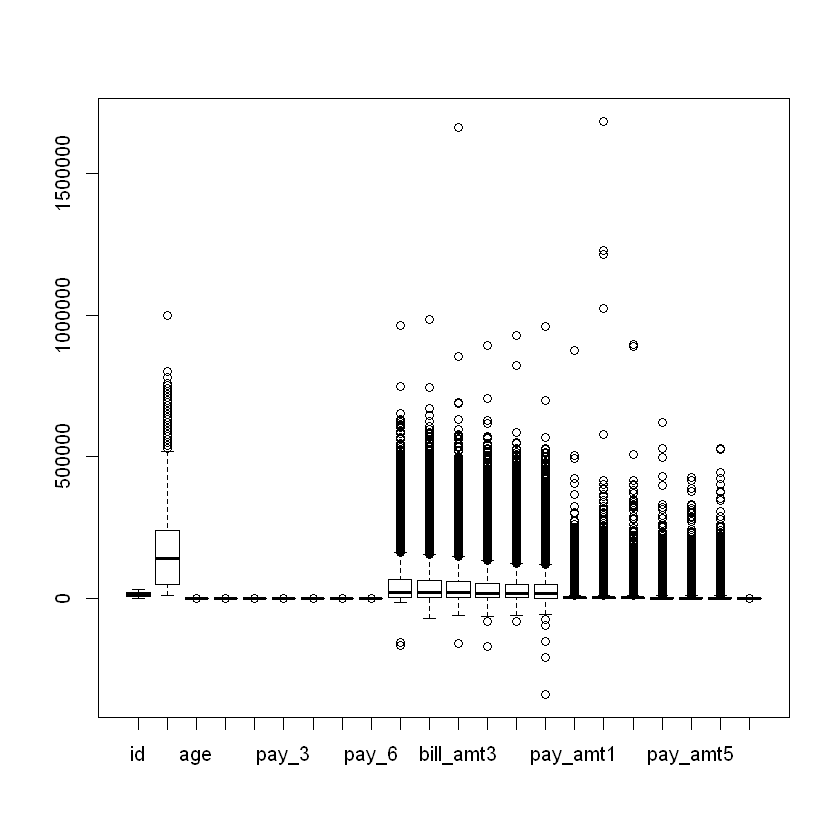

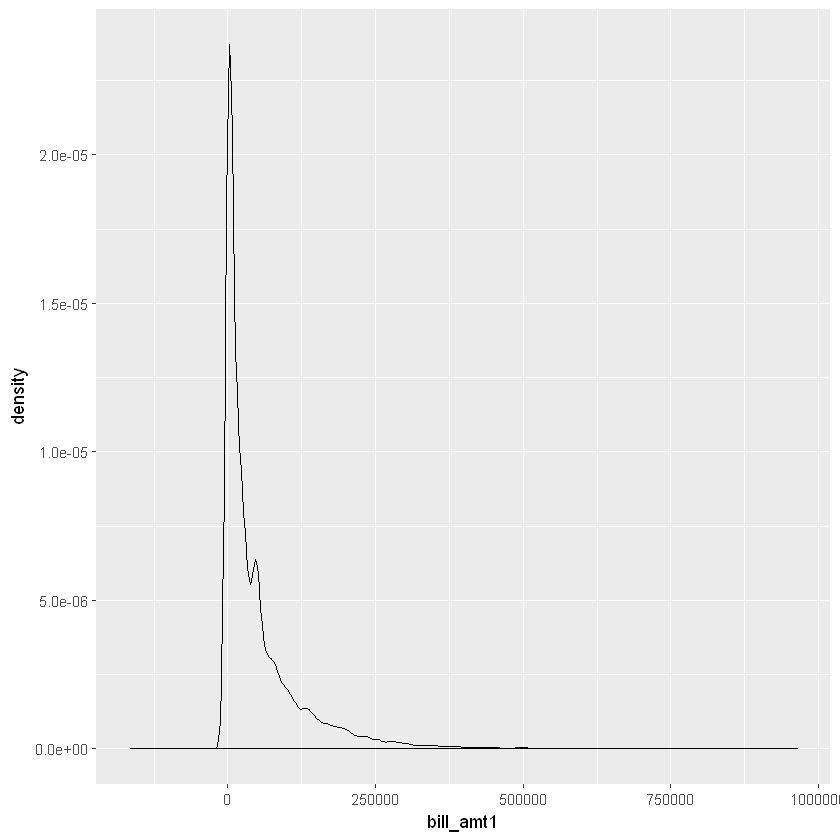

Warning message in self$trans$transform(x):
"NaNs produced"Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Removed 2598 rows containing non-finite values (stat_density)."Warning message:
"Removed 5249 rows containing non-finite values (stat_density)."

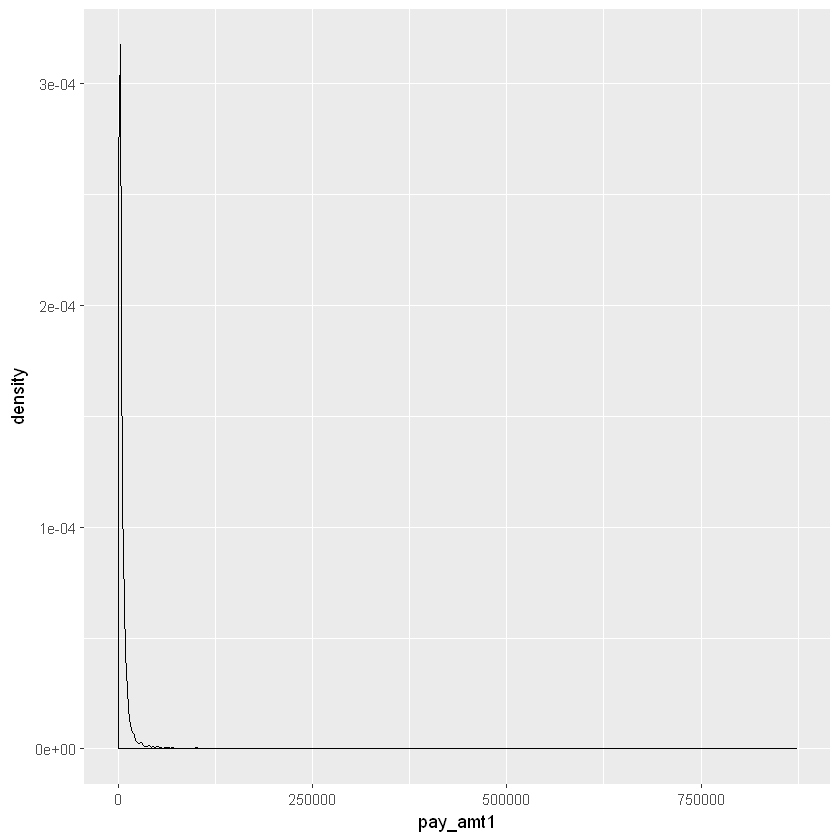

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


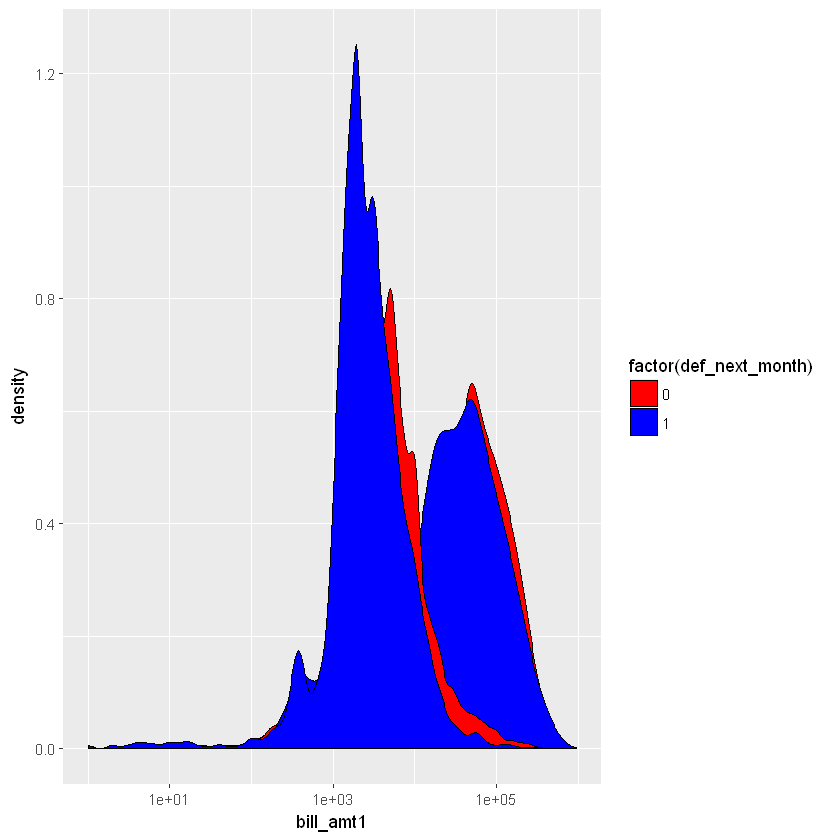

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


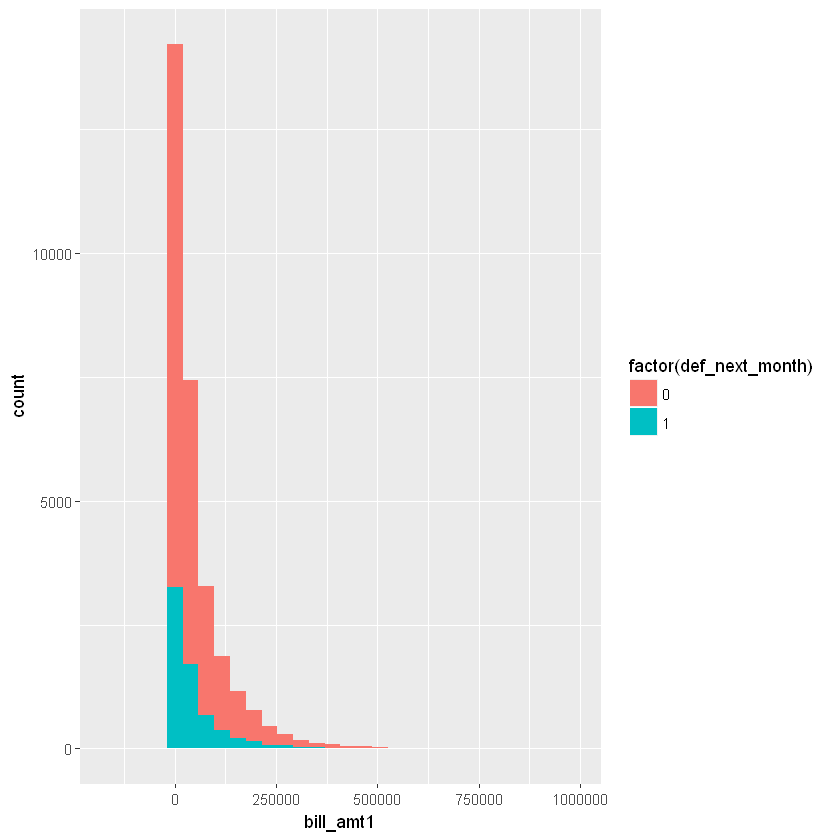

,Var1,Var2,Freq
230,bill_amt1,bill_amt2,0.9514837
322,bill_amt5,bill_amt6,0.9461968
299,bill_amt4,bill_amt5,0.9401344
253,bill_amt2,bill_amt3,0.9283263
276,bill_amt3,bill_amt4,0.9239695
321,bill_amt4,bill_amt6,0.9009410
275,bill_amt2,bill_amt4,0.8924823
252,bill_amt1,bill_amt3,0.8922785
298,bill_amt3,bill_amt5,0.8839097
274,bill_amt1,bill_amt4,0.8602722


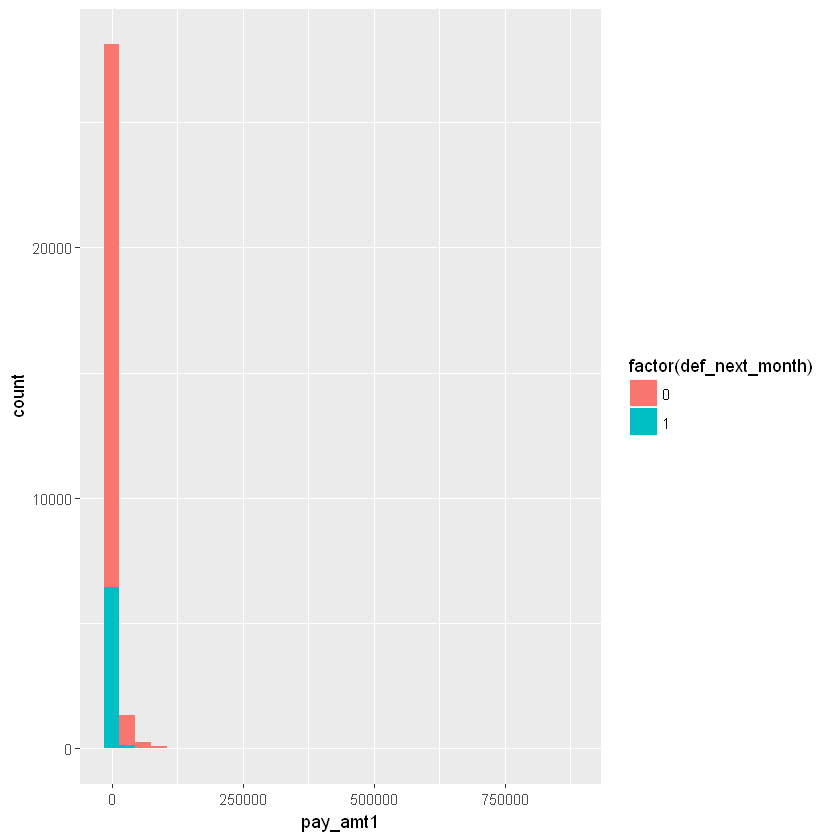

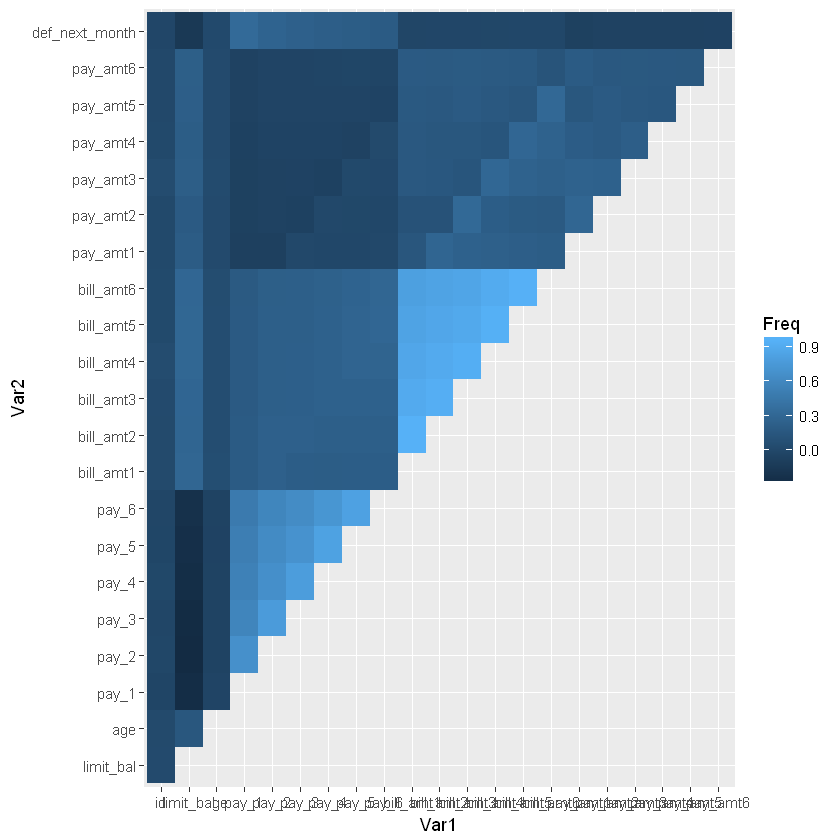

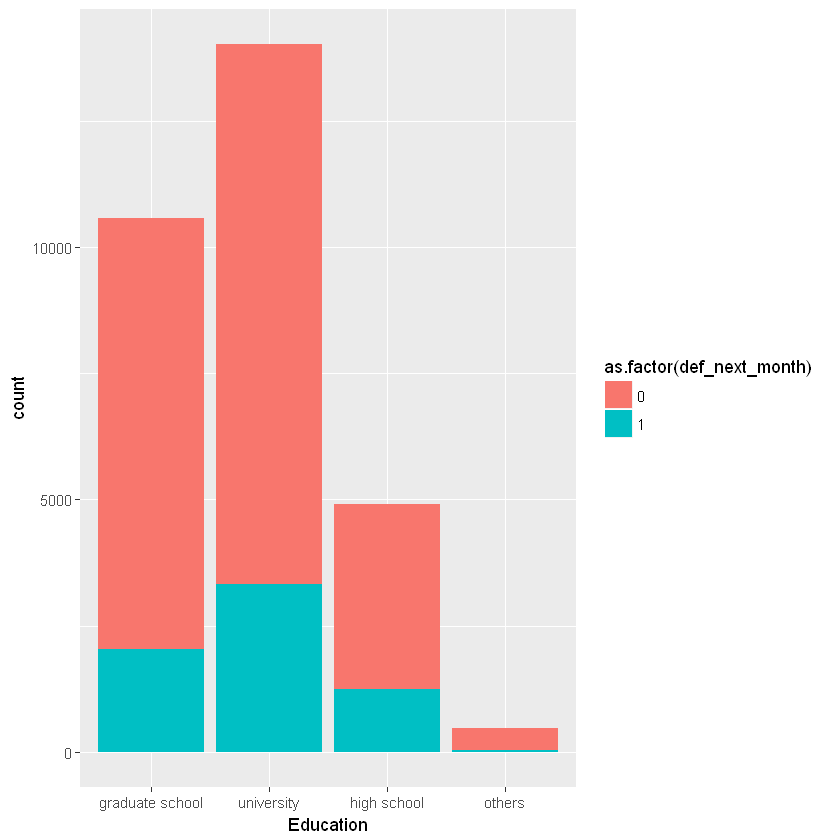

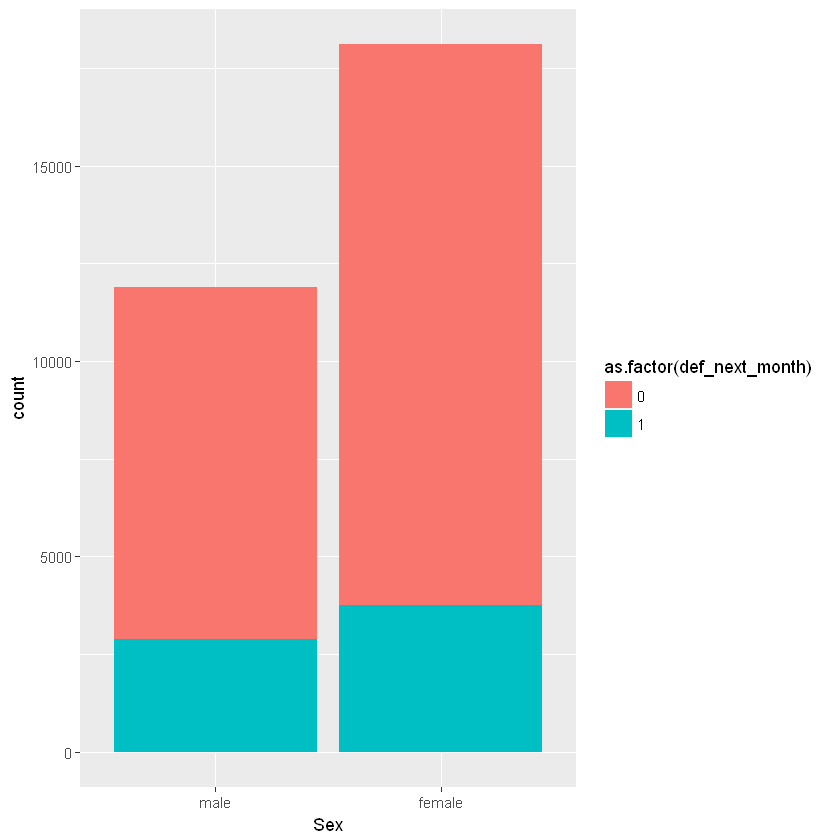

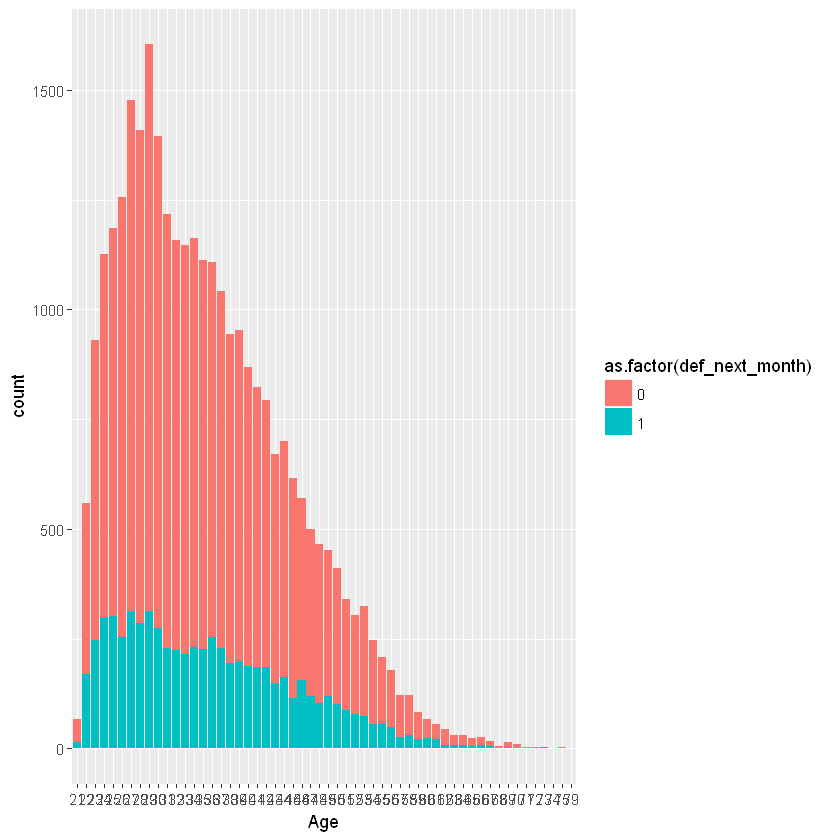

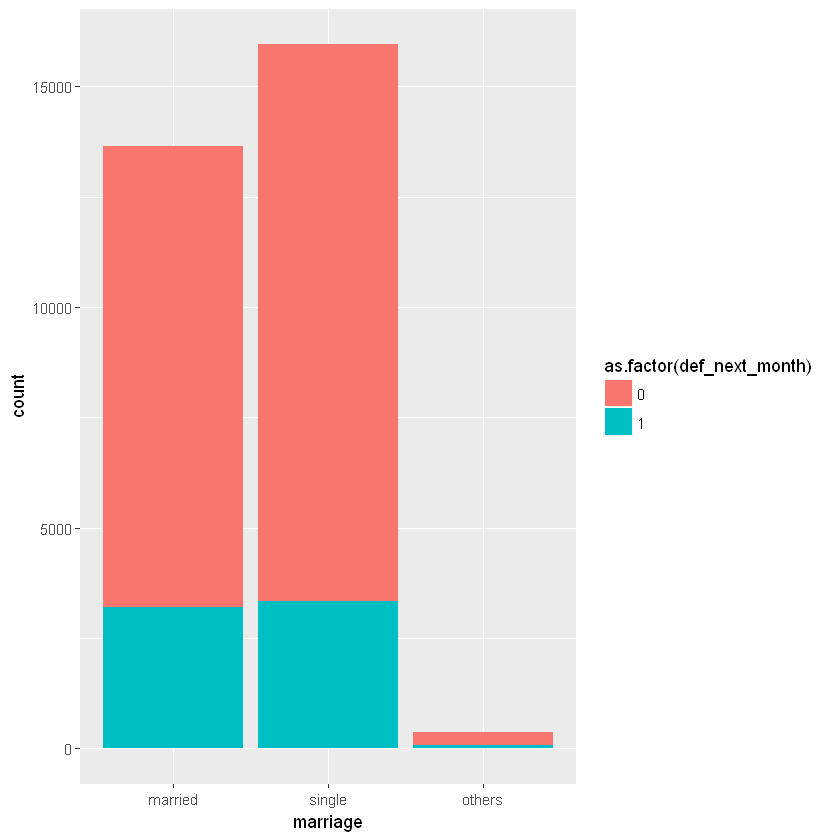

In [5]:
str(df)
summary(df)
## Levels of categorical variable looks fine
## if pay = -1 is duly paid, -2 has no meaning as per documentation.
## also the value 0 is unexplained. This also indicates 0 is duly paid

## bill payment has negative values. 
## it may indicate paid in advanced or refunds.

summary(df)
## Check any other data issues
data_issues <- apply(df, 2, function(x) length(which(x == "" | x == "?" | is.na(x) | x == "NA")))
data_issues ## No other data issues

## Boxplot - too many outliers
boxplot(df[,numVars])

## density plot
library(ggplot2)
ggplot(df) + geom_density(aes(x= bill_amt1)) ## Skewed to lower values
ggplot(df) + geom_density(aes(x= pay_amt1))  ## Very highly skewed to lower values

## Rescaling pay and bill amount into one map using ggplot density
ggplot(df) + geom_density(aes(x= bill_amt1, fill=factor(def_next_month))) + 
  geom_density(aes(x= pay_amt1, fill=factor(def_next_month))) + scale_x_log10() +
  scale_fill_manual( values = c("red","blue"))
## pay amt is highly skewed
## Indicates small portion is being paid off every month

ggplot(df) + geom_histogram(aes(x= bill_amt1, fill=factor(def_next_month))) ## Negative values. High frequency of low bill amounts
ggplot(df) + geom_histogram(aes(x= pay_amt1, fill=factor(def_next_month))) ## Very high frequency of low payments made
## Verified on other columns

## Correlation matrix
corMat <- cor(df[,numVars])

corMatrix <- corMat
corMatrix[lower.tri(corMatrix,diag=TRUE)]=NA
corMatrix=as.data.frame(as.table(corMatrix))
corMatrix=na.omit(corMatrix)
corMatrix=corMatrix[order(-abs(corMatrix$Freq)),]
corMatrix[1:10,]

ggplot(data = corMatrix, aes(x=Var1, y=Var2, fill = Freq)) + geom_tile()
## bill_amt has a strong positive relationship between consecutive months.

## Bar chart of factor variables grouping on target labels
ggplot(df, aes(x = education, fill = as.factor(def_next_month))) + 
  geom_bar() + labs(x = 'Education') + 
  scale_x_discrete(labels = c("graduate school","university", "high school", "others"))

## More university defaults. Not very conclusive as count is also more.
ggplot(df, aes(x = sex, fill = as.factor(def_next_month))) + 
  geom_bar() + labs(x = 'Sex') + scale_x_discrete(labels = c("male","female"))

## Females are slightly more defaulted. Again not very conclusive.
ggplot(df, aes(x = as.factor(age), fill = as.factor(def_next_month))) + 
  geom_bar() + labs(x = 'Age')

## More default in age group 20-30 when compared to the count
ggplot(df, aes(x = marriage, fill = as.factor(def_next_month))) + 
  geom_bar() + labs(x = 'marriage') + scale_x_discrete(labels = c("married","single","others"))
## same number of defaults

Logistic regression model to determine whether or not a customer defaulted. Using all of the variables. Validate the model on a test data set.

In [6]:
set.seed(18725)
library('caret')

## Stratefied sampling
trainPct <- .8
testPct <- 1 - trainPct
inTrain <- createDataPartition(y = df$def_next_month, p = trainPct, list = FALSE)
Train <- df[inTrain,]
Test <- df[-inTrain,]
stopifnot(nrow(Train) + nrow(Test) == nrow(df))

yVar <- 'def_next_month'
exclude <- c('id')
xVars <- names(df)[!names(df) %in% c(yVar, exclude)]

## createModelFormula already created above

modelFormGlm <- createModelFormula(yVar, xVars)
GlmModel <- glm(modelFormGlm,family=binomial(link='logit'),data = Train)
summary(GlmModel)
## Null deviance: 25223  on 23999  degrees of freedom
## Residual deviance: 22103  on 23973  degrees of freedom
## AIC: 22157

## Classify test data
fitted.results <- predict(GlmModel, newdata = Test[,xVars], type='response')
default.pred <- ifelse(fitted.results > 0.5,1,0)

## Measure performance
confusion <- confusionMatrix(data = default.pred
                             , reference = unlist(Test[,'def_next_month'])
                             , dnn = c("Predicted Default", 'Actual Default')
)
confusion

## Accuracy : 0.8015 
## Sensitivity : 0.9708          
## Specificity : 0.2364
## We can see specificity is not very high

Warning message:
"package 'caret' was built under R version 3.3.3"

ERROR: Error: package 'lattice' required by 'caret' could not be found


Using forward selection, determine the best model.

In [ ]:
## Fitting full data

library(leaps)

fullformulaNoPK <- createModelFormula(yVar, xVars)

nothing <- glm(def_next_month ~ 1, family=binomial(link='logit'), data = df)
fwmodel <- step(nothing, direction='forward', scope =list(lower=formula(nothing),upper=fullformulaNoPK ))
formula(fwmodel)
## Below is the best model generated
## AIC=27886.47
## Features: 
## def_next_month ~ limit_bal + sex + education + marriage + age + 
## pay_1 + pay_2 + pay_3 + pay_5 +
## bill_amt1 + bill_amt2 + bill_amt3 +
## pay_amt1 + pay_amt2 + pay_amt3 + pay_amt4 + pay_amt5 + pay_amt6 

Using the manual backwards selection function, determine the best model

In [ ]:
backwards(fullformulaNoPK, df)
## Below is the best model generated
## AIC : 28420.68
## Features:
## def_next_month ~ limit_bal + sex + education + marriage + age + 
## pay_1 + pay_2 + pay_3 + pay_5 + 
## bill_amt1 + bill_amt2 + 
## pay_amt1 + pay_amt2 + pay_amt4 + pay_amt5

Run an implementation of backwards selection found in an R package on this data set. Note any differences between the results of this implementation and manual implementation.

In [ ]:
library(rms)
ols.full <- ols(fullformulaNoPK, data = df)
bwmodel <- fastbw(ols.full, rule = "p", sls = 0.1)
bwmodel
## Features:
## def_next_month ~ limit_bal + sex + education + marriage + age + 
## pay_1 + pay_2 + pay_3 + pay_5 + 
## bill_amt1 + 
## pay_amt1 + pay_amt2
## fastbw considers less number of features to be important than the manual backward.

Lasso regression on the data set

In [ ]:
library(glmnet)
set.seed(18725)
formulaGLM <- paste(xVars, collapse = ' + ')
modelStrGLM <- paste('~ 0 +',formulaGLM)
xFormulaGlm <- as.formula(modelStrGLM)
yFormulaGlm <- as.formula('~ 0 + def_next_month')

## Split Stratefied sampling into x and y
xTrain <- Train[, ! names(Train) %in% c("def_next_month")]
yTrain <- Train[,"def_next_month"]
xTest <- Test[, ! names(Test) %in% c("def_next_month")]
yTest <- Test[,"def_next_month"]

## Convert model matrix
xTrain <- model.matrix(xFormulaGlm, data=xTrain)
yTrain <- model.matrix(yFormulaGlm, data=yTrain)
xTest <- model.matrix(xFormulaGlm, data=xTest)
yTest <- model.matrix(yFormulaGlm, data=yTest)

## alpha = 1 for Lasso 
cvfit = cv.glmnet(xTrain, yTrain, alpha=1, family='binomial',type.measure="mse")
plot(cvfit)
print(cvfit)
  ## cvfit$lambda.min = 0.0002208019
  ## cvfit$lambda.1se = 0.0100131
  ## coef(cvfit, s = "lambda.min")
pred_yTest <- predict(cvfit, newx = xTest, s = "lambda.min", type = "response")

## Plot confusion matrix
default.pred <- ifelse(pred_yTest > 0.5,1,0)

## Measure performance
confusion <- confusionMatrix(data = default.pred
                             , reference = unlist(yTest)
                             , dnn = c("Predicted Default", 'Actual Default'))
confusion

## Accuracy : 0.801
## Sensitivity : 0.9753         
## Specificity : 0.2075
                    ## Actual Default
## Predicted Default    0    1
                ## 0 4482 1059
                ## 1  135  324
## Lasso data is one hot encoded.
## Alpha is kept as 1 for Lasso in glmnet
## Plot cvfit gives two horizontal bars for lambda values and minimun is selected.
## Mean Squared measure is used and minimum lambda is the selected S value

Ridge regression on the data set

In [ ]:
set.seed(18725)
## alpha = 0 for Ridge 
cvfit = cv.glmnet(xTrain, yTrain, alpha=0, family='binomial',type.measure="mse")
pred_yTest <- predict(cvfit, newx = xTest, s = "lambda.min", type = "response")
plot(cvfit)

## Plot confusion matrix
default.pred <- ifelse(pred_yTest > 0.5,1,0)

## Measure performance
confusion <- confusionMatrix(data = default.pred
                             , reference = unlist(yTest)
                             , dnn = c("Predicted Default", 'Actual Default'))
confusion

## Accuracy : 0.7983
## Sensitivity : 0.9753         
## Specificity : 0.2075

## Ridge data is one hot encoded.
## Alpha is kept as 0 for Lasso in glmnet
## Plot cvfit gives two horizontal bars for lambda values and minimun is selected.
## Mean Squared measure is used and minimum lambda is the selected S value

Naive bayes on the data set

In [ ]:
library(e1071)
NB <- naiveBayes(fullformulaNoPK , data = Train)
probs <- predict(NB, newdata = Test, type = 'raw')
default.pred <- (probs[,'0'] <= probs[,'1'])*1

## Measure performance
confusion <- confusionMatrix(data = default.pred
                             , reference = unlist(Test[,'def_next_month'])
                             , dnn = c("Predicted Default", 'Actual Default'))
confusion
## Accuracy : 0.6733
## Sensitivity : 0.6656          
## Specificity : 0.6992
                  ## Actual Default
## Predicted Default    0    1
                  ## 0 3073  416
                  ## 1 1544  967

Decision tree to classify the customers as defaulted or not-defaulted

In [ ]:
library(rpart)
DT <- rpart(fullformulaNoPK, data=Train, method="class")
summary(DT)
default.pred <- predict(DT, Test, type = "class")

## Measure performance
confusion <- confusionMatrix(data = default.pred
                             , reference = unlist(Test[,'def_next_month'])
                             , dnn = c("Predicted Default", 'Actual Default'))
confusion
## Accuracy : 0.8103
## Sensitivity : 0.9580          
## Specificity : 0.3174
                  ## Actual Default
## Predicted Default    0    1
                  ## 0 4423  944
                  ## 1  194  439
## Pay_1 is the most important feature
## Plot decision tree
library('rattle')
library('rpart.plot')
fancyRpartPlot(DT)

Random Forest on the data set

In [ ]:
library(randomForest)

fullformulaYFactored <- createModelFormula('as.factor(def_next_month)', xVars)
RF <- randomForest(fullformulaYFactored, data=Train, importance=TRUE, ntree=200)
RF
importance(RF, type=2)
default.pred <- predict(RF, Test, type = "class")

## Measure performance
confusion <- confusionMatrix(data = default.pred
                             , reference = unlist(Test[,'def_next_month'])
                             , dnn = c("Predicted Default", 'Actual Default'))
confusion
## Accuracy : 0.812
## Sensitivity : 0.9452          
## Specificity : 0.3673

Summary ::
Naive Bayes is not a good fit.
glm, DT, Random Forest has an accuracy close to each other.
Lasso glm has more or less same performance as glm with full set. Ridge is lower.
Random forest has slightly better accuracy with 200 trees.
Sensitivity is high for glm and lasso but specificity reduces.
Random forest has a better balance of accuracy, sensitivity and specificity.
Random forest might be best suited for this. Performance can be improved more by parameter tuning.